<a href="https://colab.research.google.com/github/abihlo/pinnSWE/blob/main/pinnSWE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, Flatten, Add, Lambda, Permute, \
    LSTM, GRU, Conv1D, Concatenate, BatchNormalization, TimeDistributed, RepeatVector, Activation
from tensorflow.keras.models import Model, load_model

from tensorflow.keras import metrics, losses
from tensorflow.keras import backend as K

In [2]:
# This is the SWE solver
class SWE():
  def __init__(self, input_steps=5, output_steps=1, n=100, 
               H=10, T=0.25, dt=0.001, step_size=5):

    # Define grid
    grd = np.linspace(-1,1,n+1)
    self.x = grd[:-1]
    self.dx = self.x[1] - self.x[0]
    self.T = T
    self.dt = dt
    self.step_size = 5

    # Initialize the bottom topography and solution components
    self.b = np.zeros(n)
    self.H = H

    # Number of input steps and output steps for NN
    self.input_steps = input_steps
    self.output_steps = output_steps

    # Total number of grid points
    self.n = np.int(n)

    # Gravitational acceleration
    self.g = 1
  

  def define_bottom_profile(self, nr):
    if nr == 1:
      self.b = 0*self.x
    if nr == 2:
      self.b = np.cos(self.x)
    if nr == 3:
      self.b = np.exp(-(4*self.x)**2)


  def generate_random_wave_solution(self, nr_waves):
    u = np.zeros(self.n)
    h = np.zeros(self.n)
    for i in range(nr_waves):
      h += np.random.rand()*np.sin(np.pi*(np.random.randint(0,8)*(self.x+np.pi*np.random.rand())))
    return u,  h + self.H - self.b


  def generate_simple_wave_solution(self, amplitude=1, wave_nr=1):
    u = np.zeros(self.n)
    h = amplitude*np.sin(np.pi*(wave_nr*self.x)) + self.H - self.b
    return u, h


  def generate_gaussian_bumps(self, nr_bumps=1, max_amplitude=1, max_decay=4, min_decay=2):
    u = np.zeros(self.n)
    h = np.zeros(self.n)
    
    for i in range(nr_bumps):
      decay = (max_decay-min_decay)*np.random.rand() + min_decay
      curr_h = max_amplitude*np.random.rand()*np.exp(-0.5*(decay*self.x)**2)
      curr_h = np.roll(curr_h, np.random.randint(0,self.n-1))
      if np.random.rand() < 0.5:
        h += curr_h
      else:
        h -= curr_h
    h += (self.H-self.b)

    return u, h


  def extend_periodic(self, f):

    f_ext = np.zeros(self.n+2)
    f_ext[1:-1] = f
    f_ext[0] = f[-1]
    f_ext[-1] = f[0]

    return f_ext


  # Lax-Wendroff for SWE
  def solve(self, u, h, steps):

    q = u*h

    sol_h = np.zeros((steps, self.n))
    sol_u = np.zeros((steps, self.n))

    sol_h[0] = h
    sol_u[0] = u

    zeros = np.zeros(self.n)
 
    for i in range(steps-1):

      h_ext = self.extend_periodic(h)
      q_ext = self.extend_periodic(q)

      h12p = 1/2*(h_ext[2:] + h_ext[1:-1]) - self.dt/(2*self.dx)*(q_ext[2:]-q_ext[1:-1])
      h12m = 1/2*(h_ext[1:-1] + h_ext[0:-2]) - self.dt/(2*self.dx)*(q_ext[1:-1]-q_ext[0:-2])

      q12p = 1/2*(q_ext[2:] + q_ext[1:-1]) - self.dt/(2*self.dx)*(q_ext[2:]**2/h_ext[2:]+1/2*self.g*h_ext[2:]**2-q_ext[1:-1]**2/h_ext[1:-1]-1/2*self.g*h_ext[1:-1]**2)
      q12m = 1/2*(q_ext[1:-1] + q_ext[0:-2]) - self.dt/(2*self.dx)*(q_ext[1:-1]**2/h_ext[1:-1]+1/2*self.g*h_ext[1:-1]**2-q_ext[0:-2]**2/h_ext[0:-2]-1/2*self.g*h_ext[0:-2]**2)

      h = h - self.dt/self.dx*(q12p - q12m)
      q = q - self.dt/self.dx*(q12p**2/h12p + 1/2*self.g*h12p**2 - q12m**2/h12m - 1/2*self.g*h12m**2)

      sol_h[i+1] = h
      sol_u[i+1] = q/h
    
    return sol_u, sol_h 


  def plot_sample(self, x_u, x_h, y_u, y_h):

    for i in range(self.input_steps+self.output_steps):
      plt.subplot(211)
      if i < self.input_steps:
        plt.plot(self.x, x_u[i,],'b')
      else:
        plt.plot(self.x, y_u[i-self.input_steps,],'b--')
      plt.xlabel('x')
      plt.ylabel('u')
      plt.grid()

      plt.subplot(212)
      if i < self.input_steps:
        plt.plot(self.x, x_h[i, ],'k')
      else:
        plt.plot(self.x, y_h[i-self.input_steps, ],'k--')
      plt.xlabel('x')
      plt.ylabel('h')
      plt.grid()
    

  # Generate the NN dataset
  def generate_dataset(self, nr_train, nr_test):

    x_train_u = np.zeros((nr_train, self.input_steps, self.n))
    x_train_h = np.zeros((nr_train, self.input_steps, self.n))
    y_train_u = np.zeros((nr_train, self.output_steps, self.n))
    y_train_h = np.zeros((nr_train, self.output_steps, self.n))

    x_test_u = np.zeros((nr_test, self.input_steps, self.n))
    x_test_h = np.zeros((nr_test, self.input_steps, self.n))
    y_test_u = np.zeros((nr_test, self.output_steps, self.n))
    y_test_h = np.zeros((nr_test, self.output_steps, self.n))

    # This is the number of integration steps
    steps = np.int(self.T//self.dt)

    for i in range(nr_train):
      
      # Generate an initial condition and solve the SWE
      u, h = self.generate_gaussian_bumps(nr_bumps=np.random.randint(1,5), max_amplitude=2*np.random.rand(), max_decay=6, min_decay=3)
      sol_u, sol_h = self.solve(u, h, np.int(self.T//self.dt))

      # Store the solution at input_steps/output_steps randomly selected points
      first_step = np.random.randint(0, steps-self.step_size*(self.input_steps+self.output_steps))
      for j in range(self.input_steps):
        x_train_u[i,j,] = sol_u[first_step+j*self.step_size,:]
        x_train_h[i,j,] = sol_h[first_step+j*self.step_size,:]
      for j in range(self.input_steps, self.input_steps+self.output_steps):
        y_train_u[i,j-self.input_steps,] = sol_u[first_step+j*self.step_size,:]
        y_train_h[i,j-self.input_steps,] = sol_h[first_step+j*self.step_size,:]

    for i in range(nr_test):
      
      # Generate an initial condition and solve the SWE
      u, h = self.generate_gaussian_bumps(nr_bumps=np.random.randint(1,5), max_amplitude=1*np.random.rand(), max_decay=6, min_decay=3)
      sol_u, sol_h = self.solve(u, h, np.int(self.T//self.dt))

      first_step = np.random.randint(0, steps-self.step_size*(self.input_steps+self.output_steps))
      for j in range(self.input_steps):
        x_test_u[i,j,] = sol_u[first_step+j*self.step_size,:]
        x_test_h[i,j,] = sol_h[first_step+j*self.step_size,:]
      for j in range(self.input_steps, self.input_steps+self.output_steps):
        y_test_u[i,j-self.input_steps,] = sol_u[first_step+j*self.step_size,:]
        y_test_h[i,j-self.input_steps,] = sol_h[first_step+j*self.step_size,:]

    # Max and min/mean and std of training data (for normalization/standardization)
    self.mean_u = x_train_u.mean()
    self.mean_h = x_train_h.mean()
    self.std_u = x_train_u.std()
    self.std_h = x_train_h.std()

    self.min_u = x_train_u.min()
    self.max_u = x_train_u.max()
    self.min_h = x_train_h.min()
    self.max_h = x_train_h.max()    

    return (x_train_u, x_train_h, y_train_u, y_train_h), (x_test_u, x_test_h, y_test_u, y_test_h)


  def standardize_data(self, x_u, x_h, y_u, y_h):

    x_u_norm = (x_u-self.mean_u)/self.std_u
    x_h_norm = (x_h-self.mean_h)/self.std_h
    y_u_norm = (y_u-self.mean_u)/self.std_u
    y_h_norm = (y_h-self.mean_h)/self.std_h

    return (x_u_norm, x_h_norm, y_u_norm, y_h_norm)


  def destandardize_data(self, u, h):

    u_denorm = self.std_u*u+self.mean_u
    h_denorm = self.std_h*h+self.mean_h

    return (u_denorm, h_denorm)


  def normalize_data(self, x_u, x_h, y_u, y_h):

    x_u_norm = 2*(x_u-self.min_u)/(self.max_u-self.min_u)-1.0
    x_h_norm = 2*(x_h-self.min_h)/(self.max_h-self.min_h)-1.0

    y_u_norm = 2*(y_u-self.min_u)/(self.max_u-self.min_u)-1.0
    y_h_norm = 2*(y_h-self.min_h)/(self.max_h-self.min_h)-1.0

    return (x_u_norm, x_h_norm, y_u_norm, y_h_norm)


  def denormalize_data(self, u, h):

    u_denorm = 0.5*(u + 1)*(self.max_u-self.min_u) + self.min_u
    h_denorm = 0.5*(h + 1)*(self.max_h-self.min_h) + self.min_h

    return (u_denorm, h_denorm)


  def define_lstm_nn(self, nr_units=32, dropout_rate=0.25):

    input_layer_u = Input(shape=(self.input_steps, self.n))
    input_layer_h = Input(shape=(self.input_steps, self.n))

    # b_u = BatchNormalization()(input_layer_u)
    # b_h = BatchNormalization()(input_layer_h)

    b_u = LSTM(nr_units)(input_layer_u)
    b_h = LSTM(nr_units)(input_layer_h)

    b = Concatenate(axis=1)([b_u,b_h])
    b = Dropout(dropout_rate)(b)
    b = Reshape([self.output_steps, -1])(b)

    out_u = LSTM(self.n, return_sequences=True)(b)
    out_h = LSTM(self.n, return_sequences=True)(b)

    # out_u = TimeDistributed(Dense(self.n, activation='linear'))(out_u)
    # out_h = TimeDistributed(Dense(self.n, activation='linear'))(out_h)

    self.model = Model([input_layer_u, input_layer_h], [out_u, out_h])
    self.model.compile(optimizer='adam',loss='mse')
    self.model.summary()


  def define_lstm_resnet(self, nr_units=32, dropout_rate=0.25):

    # Weight initialization
    # init = tf.random_normal_initializer(0., 0.02)

    input_layer_u = Input(shape=(self.input_steps, self.n))
    input_layer_h = Input(shape=(self.input_steps, self.n))

    last_in_u = Lambda(lambda x: tf.slice(x, [0,self.input_steps-1,0], [-1,self.output_steps, self.n]), 
                       output_shape=(self.output_steps, self.n))(input_layer_u)
    last_in_h = Lambda(lambda x: tf.slice(x, [0,self.input_steps-1,0], [-1,self.output_steps, self.n]), 
                       output_shape=(self.output_steps, self.n))(input_layer_h)

    b_u = LSTM(nr_units)(input_layer_u)
    b_h = LSTM(nr_units)(input_layer_h)

    b = Concatenate(axis=1)([b_u, b_h])
    b = Dropout(dropout_rate)(b)
    b = Reshape([self.output_steps, -1])(b)

    out_u = LSTM(self.n, return_sequences=True)(b)
    out_h = LSTM(self.n, return_sequences=True)(b)

    out_u = Add()([last_in_u, out_u])
    out_h = Add()([last_in_h, out_h])

    self.model = Model([input_layer_u, input_layer_h], [out_u, out_h])
    self.model.compile(optimizer='adam',loss='mse')
    self.model.summary()


  def define_mlp(self, nr_units=64, dropout_rate=0.25):

    input_layer_u = Input(shape=(self.input_steps, self.n))
    input_layer_h = Input(shape=(self.input_steps, self.n))

    b_u = TimeDistributed(Dense(nr_units, activation='relu'))(input_layer_u)
    b_h = TimeDistributed(Dense(nr_units, activation='relu'))(input_layer_h)

    b = Concatenate(axis=1)([b_u, b_h])
    b = Dense(self.output_steps*nr_units)(b)
    b = Dropout(dropout_rate)(b)
    b = Reshape([self.output_steps, -1])(b)

    out_u = TimeDistributed(Dense(self.n, activation='tanh'))(b)
    out_h = TimeDistributed(Dense(self.n, activation='tanh'))(b)

    self.model = Model([input_layer_u, input_layer_h], [out_u, out_h])    
    self.model.compile(optimizer='adam', loss='mse')
    self.model.summary()


  def define_mlp_resnet(self, nr_units=32, dropout_rate=0.25):

    # Weight initialization
    # init = tf.random_normal_initializer(0., 0.02)

    input_layer_u = Input(shape=(self.input_steps, self.n))
    input_layer_h = Input(shape=(self.input_steps, self.n))

    last_in_u = Lambda(lambda x: tf.slice(x, [0,self.input_steps-1,0], [-1,self.output_steps, self.n]), 
                       output_shape=(self.output_steps, self.n))(input_layer_u)
    last_in_h = Lambda(lambda x: tf.slice(x, [0,self.input_steps-1,0], [-1,self.output_steps, self.n]), 
                       output_shape=(self.output_steps, self.n))(input_layer_h)

    b_u = TimeDistributed(Dense(nr_units, activation='relu'))(input_layer_u)
    b_h = TimeDistributed(Dense(nr_units, activation='relu'))(input_layer_h)

    b = Concatenate(axis=1)([b_u, b_h])
    b = Dense(self.output_steps*nr_units)(b)
    b = Dropout(dropout_rate)(b)
    b = Reshape([self.output_steps, -1])(b)

    b_u = TimeDistributed(Dense(self.n, activation='tanh'))(b)
    b_h = TimeDistributed(Dense(self.n, activation='tanh'))(b)

    out_u = Add()([last_in_u, b_u])
    out_h = Add()([last_in_h, b_h])

    self.model = Model([input_layer_u, input_layer_h], [out_u, out_h])
    self.model.compile(optimizer='adam',loss='mse')
    self.model.summary()


  def define_cnn(self, nr_filters=64):

    input_layer_u = Input(shape=(self.input_steps, self.n))
    input_layer_h = Input(shape=(self.input_steps, self.n))

    # The convolution should be over time, so we need to permute space <-> time
    b_u = Permute((2,1))(input_layer_u)
    b_h = Permute((2,1))(input_layer_h)

    b_u = Conv1D(nr_filters, kernel_size=1, padding='same', activation='relu')(b_u)
    b_h = Conv1D(nr_filters, kernel_size=1, padding='same', activation='relu')(b_h)

    b = Concatenate(axis=2)([b_u, b_h])
    b = Conv1D(nr_filters, kernel_size=3, padding='same', activation='relu')(b)
    b = Conv1D(nr_filters, kernel_size=3, padding='same', activation='relu')(b)

    b_u = Conv1D(self.output_steps, kernel_size=1, padding='same', activation='tanh')(b)
    b_h = Conv1D(self.output_steps, kernel_size=1, padding='same', activation='tanh')(b)
    out_u = Permute((2,1))(b_u)
    out_h = Permute((2,1))(b_h)

    self.model = Model([input_layer_u, input_layer_h], [out_u, out_h])    
    self.model.compile(optimizer='adam', loss='mse')
    self.model.summary()


  # Conservative loss for h is linear combination of mse and mass conservation
  def conservative_loss(self, y_true, y_pred):

    return K.mean(K.square(y_true - y_pred)) + K.mean(K.sum(y_true - y_pred, axis=[1,2]))


  def train_nn(self, x_train_u, x_train_h, y_train_u, y_train_h, bs=32, epochs=80):

    self.model.fit(x=[x_train_u, x_train_h], 
                   y=[y_train_u, y_train_h], batch_size=bs, 
                   epochs=40, validation_split=0.1, 
                   callbacks=tf.keras.callbacks.EarlyStopping(patience=4))


  def predict_multistep(self, x_u, x_h, nr_steps=12):

    u_in = x_u.copy()
    h_in = x_h.copy()

    u_out = np.zeros((nr_steps, self.n))
    h_out = np.zeros((nr_steps, self.n))

    # Get the neural network multistep prediction
    for i in range(nr_steps):

      (u_curr, h_curr) = self.model.predict([np.expand_dims(u_in, axis=0),
                                 np.expand_dims(h_in, axis=0)])
      u_in[:self.input_steps-1,] = u_in[1:,]
      u_in[self.input_steps-1,] = u_curr[0,]

      h_in[:self.input_steps-1,] = h_in[1:,]
      h_in[self.input_steps-1,] = h_curr[0,]

      u_out[i, ] = u_curr
      h_out[i, ] = h_curr

    # Reverse the normalization
    (u_out, h_out) = self.denormalize_data(u_out, h_out)

    # Get the numerical solution
    (x_u, x_h) = self.denormalize_data(x_u, x_h)
    (u_num, h_num) = self.solve(x_u[-1,], x_h[-1,], (nr_steps+1)*self.step_size)
    u_num = u_num[self.step_size::self.step_size,]
    h_num = h_num[self.step_size::self.step_size,]

    return (u_num, h_num), (u_out, h_out)


  def predict(self, x_u, x_h):

    # Predict
    (y_pred_u, y_pred_h) = self.model.predict([np.expand_dims(x_u, axis=0),
                                 np.expand_dims(x_h, axis=0)])
    
    return (y_pred_u, y_pred_h)


  def plot_prediction_multistep(self, y_u, y_h, y_u_pred, y_h_pred, 
                                plot_increment=5):

    # Plot the solution at plot_increment time steps
    plot_steps = y_u.shape[0]//plot_increment
    for i in range(plot_steps):
      plt.subplot(211)
      plt.plot(self.x, y_u_pred[plot_increment*i,].flatten(),'k')
      plt.plot(self.x, y_u[plot_increment*i,].flatten(),'b--')
      plt.legend(['prediction','truth'])
      plt.xlabel('x')
      plt.ylabel('u')
      plt.grid()

      plt.subplot(212)
      plt.plot(self.x, y_h_pred[plot_increment*i,].flatten(),'k')
      plt.plot(self.x, y_h[plot_increment*i,].flatten(),'b--')
      plt.legend(['prediction','truth'])
      plt.xlabel('x')
      plt.ylabel('h')
      plt.grid()
    
    plt.show()


  def plot_prediction(self, y_u, y_h, y_u_pred, y_h_pred):

    # Reverse the normalization
    (y_u_pred, y_h_pred) = self.denormalize_data(y_u_pred, y_h_pred)
    (y_u, y_h) = self.denormalize_data(y_u, y_h)

    for i in range(self.output_steps):
      plt.subplot(211)
      plt.plot(self.x, y_u_pred[i,].flatten(),'k')
      plt.plot(self.x, y_u[i,].flatten(),'b--')
      plt.legend(['prediction','truth'])
      plt.xlabel('x')
      plt.ylabel('u')
      plt.grid()

      plt.subplot(212)
      plt.plot(self.x, y_h_pred[i,].flatten(),'k')
      plt.plot(self.x, y_h[i,].flatten(),'b--')
      plt.legend(['prediction','truth'])
      plt.xlabel('x')
      plt.ylabel('h')
      plt.grid()

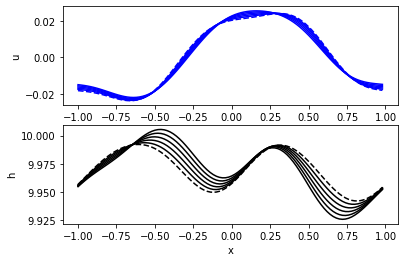

In [3]:
nr_train = 10000
nr_test = 20

swe = SWE()
(x_train_u, x_train_h, y_train_u, y_train_h), (x_test_u, x_test_h, y_test_u, y_test_h) = swe.generate_dataset(nr_train, nr_test)

s = np.random.randint(0, nr_train)
swe.plot_sample(x_train_u[s,], x_train_h[s, ], y_train_u[s,], y_train_h[s,])

In [4]:
# Normalize the training data and test data
(x_train_u, x_train_h, y_train_u, y_train_h) = swe.normalize_data(x_train_u, x_train_h, y_train_u, y_train_h)
(x_test_u, x_test_h, y_test_u, y_test_h) = swe.normalize_data(x_test_u, x_test_h, y_test_u, y_test_h)

In [5]:
# Define network type

# swe.define_lstm_nn()
# swe.define_lstm_resnet()

# swe.define_cnn()

# swe.define_mlp()
swe.define_mlp_resnet()

# Train NN
swe.train_nn(x_train_u, x_train_h, y_train_u, y_train_h)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 100)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5, 100)]     0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 5, 32)        3232        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 32)        3232        input_2[0][0]                    
______________________________________________________________________________________________

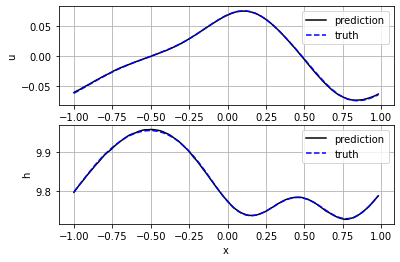

In [6]:
# Predict solution
s = np.random.randint(0, nr_test)
(y_pred_u, y_pred_h) = swe.predict(x_test_u[s,], x_test_h[s,])
swe.plot_prediction(y_test_u[s,], y_test_h[s,], y_pred_u[0,], y_pred_h[0,])

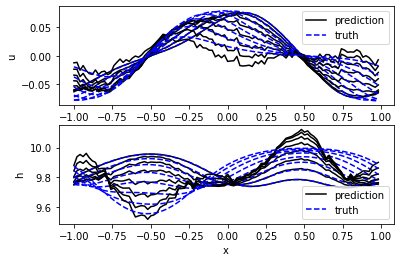

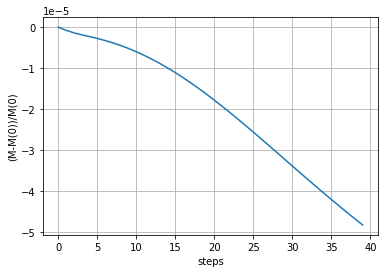

In [7]:
# Predict multiple steps
s = np.random.randint(0, nr_test)
(u_num, h_num), (u_pred, h_pred) = swe.predict_multistep(x_test_u[s,], x_test_h[s,], nr_steps=40)
swe.plot_prediction_multistep(u_num, h_num, u_pred, h_pred)

# Plot the time series of mass conservation
plt.plot((np.sum(h_pred, axis=1)- np.sum(h_pred[0,]))/np.sum(h_pred[0,]))
plt.xlabel('steps')
plt.ylabel('(M-M(0))/M(0)')
plt.grid()